# ETL and OLAP with Sales Analysis using PostgreSQL
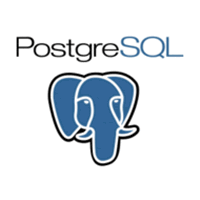

### In this project, I expressed “complex” OLAP queries in SQL. The key point of the project is to observe a large gap between the complexity of expressing the type of such queries and that of evaluating them (such as writing Java programs to produce the same results). My mission (in addition to writing the SQL queries) is to consider the reasons for the gap (between the expression and evaluation of such queries) and how to narrow it.

#### Import the library 

In [1]:
import psycopg2
import pandas as pd
import re
import warnings

In [2]:
pd.set_option('display.width', 1000)
warnings.filterwarnings("ignore")

### Create a connection to the database

In [3]:
try: 
    conn = psycopg2.connect("host=127.0.0.1 dbname=CS-561 user=postgres password=327961")
except psycopg2.Error as e: 
    print("Error: Could not make connection to the Postgres database")
    print(e)

### Use the connection to get a cursor that can be used to execute queries.

In [4]:
try: 
    cur = conn.cursor()
except psycopg2.Error as e: 
    print("Error: Could not get curser to the Database")
    print(e)

In [5]:
# Set automatic commit to be true so that each action is committed 
#without having to call conn.commit() after each command.
conn.set_session(autocommit=True)

### Create a database to do the work in. 

In [6]:
try: 
    cur.execute("CREATE DATABASE testing")
except psycopg2.Error as e:
    print(e)

database "testing" already exists



In [7]:
# close our connection to the testing database
try: 
    conn.close()
except psycopg2.Error as e:
    print(e)

# reconnect to the CS-561 database, and get a new cursor.
try: 
    conn = psycopg2.connect("host=127.0.0.1 dbname=CS-561 user=postgres password=327961")
except psycopg2.Error as e: 
    print("Error: Could not make connection to the CS-561 database")
    print(e)
    
try: 
    cur = conn.cursor()
except psycopg2.Error as e: 
    print("Error: Could not get cursor to the Database")
    print(e)

conn.set_session(autocommit=True)

### Create a Sales Table that contains a combinenation of customer, product, month, transaction day, transaction month, transaction year, transaction state, and transaction quantity.

In [8]:
#Clean up the database
try: 
    cur.execute("""DROP VIEW IF EXISTS avg_q, month_prod,
                current_month,this_month, comb, combination, v2, v3,base;""")
except psycopg2.Error as e: 
    print("Error: Issue dropping table")
    print (e)

In [9]:
## TO-DO: Finish writing the CREATE TABLE statement with the correct arguments
try: 
    cur.execute("DROP TABLE IF EXISTS sales;")
except psycopg2.Error as e: 
    print("Error: Issue creating table")
    print (e)
    
try: 
    cur.execute("""CREATE TABLE IF NOT EXISTS sales (cust varchar(20),prod varchar(20),
                   day int,month int,year int,state char(2),quant integer);""")
except psycopg2.Error as e: 
    print("Error: Issue creating table")
    print (e)

### Insert the sales data into the table

In [10]:
#Read data from external resource
raw_data = pd.read_table('sales.txt',names = ['query'])
print(raw_data.shape)
raw_data.head()

(500, 1)


,query
0,"insert into sales values ('Bloom', 'Pepsi', 2,..."
1,"insert into sales values ('Knuth', 'Bread', 23..."
2,"insert into sales values ('Emily', 'Pepsi', 22..."
3,"insert into sales values ('Emily', 'Fruits', 1..."
4,"insert into sales values ('Helen', 'Milk', 7, ..."


In [27]:
#Parse the data to insert
def extract(text):
    return re.findall(r"\w+\s\w+\s\w+\s\w+\s\W+(\w+)\W+(\w+)\W+(\w+)\W+(\w+)\W+(\w+)\W+(\w+)\W+(\w+)",text)[0]

clean_data = raw_data['query'].map(lambda x: extract(x)).tolist()
records_to_insert = [(x[0], x[1], int(x[2]), int(x[3]), \
                      int(x[4]), x[5], int(x[6])) for x in clean_data]

In [12]:
print("The number of instances to insert: ",len(records_to_insert))
print("\nThe data after processed: ")
records_to_insert

The number of instances to insert:  500

The data after processed: 


[('Bloom', 'Pepsi', 2, 12, 2001, 'NY', 4232),
 ('Knuth', 'Bread', 23, 5, 2005, 'PA', 4167),
 ('Emily', 'Pepsi', 22, 1, 2006, 'CT', 4404),
 ('Emily', 'Fruits', 11, 1, 2000, 'NJ', 4369),
 ('Helen', 'Milk', 7, 11, 2006, 'CT', 210),
 ('Emily', 'Soap', 2, 4, 2002, 'CT', 2549),
 ('Bloom', 'Eggs', 30, 11, 2000, 'NJ', 559),
 ('Bloom', 'Yogurt', 25, 7, 2004, 'PA', 17),
 ('Helen', 'Pepsi', 14, 3, 2002, 'NJ', 3891),
 ('Emily', 'Bread', 28, 9, 2005, 'PA', 42),
 ('Sam', 'Cookies', 20, 11, 2004, 'NY', 3376),
 ('Knuth', 'Milk', 5, 2, 2007, 'PA', 126),
 ('Helen', 'Coke', 11, 4, 2001, 'NY', 668),
 ('Emily', 'Butter', 5, 7, 2005, 'NJ', 3840),
 ('Emily', 'Yogurt', 7, 10, 2005, 'NY', 730),
 ('Sam', 'Soap', 12, 2, 2001, 'NJ', 165),
 ('Knuth', 'Coke', 6, 1, 2003, 'CT', 1557),
 ('Sam', 'Milk', 9, 8, 2001, 'NY', 1132),
 ('Helen', 'Yogurt', 6, 2, 2000, 'PA', 4001),
 ('Sam', 'Milk', 6, 1, 2003, 'PA', 2298),
 ('Knuth', 'Pepsi', 21, 12, 2008, 'CT', 653),
 ('Knuth', 'Eggs', 19, 12, 2006, 'NJ', 1339),
 ('Helen', 'C

In [13]:
#Insert data to the sales table
def bulkInsert(records):
    try:
        sql_insert_query = """ INSERT INTO sales (cust, prod, day, month ,year, state, quant) 
                           VALUES (%s,%s,%s,%s,%s,%s,%s) """
        # executemany() to insert multiple rows rows
        result = cur.executemany(sql_insert_query, records)
        print(cur.rowcount, "Record inserted successfully into mobile table")
    except (Exception, psycopg2.Error) as error:
        print("Failed inserting record into mobile table {}".format(error))

bulkInsert(records_to_insert)

500 Record inserted successfully into mobile table


In [14]:
# Validate the data was inserted into the table.
try: 
    cur.execute("""SELECT COUNT(*) FROM sales;""")
except psycopg2.Error as e: 
    print("Error: select *")
    print (e)
    
row = cur.fetchone()
while row:
   print(row)
   row = cur.fetchone()

(500,)


### Take a look at the sales table

In [15]:
try: 
    cur.execute("""SELECT * FROM sales;""")
except psycopg2.Error as e: 
    print("Error: select *")
    print (e)

row = cur.fetchone()
sales = []
while row:
   sales.append(row)
   row = cur.fetchone()

sales_table = pd.DataFrame(sales, columns = ['Customer', 'Product', 'Date,','Month', 'Year',\
                                       'State', 'Qutant'])
print(sales_table.shape)
print(sales_table)

(500, 7)
    Customer  Product  Date,  Month  Year State  Qutant
0      Bloom    Pepsi      2     12  2001    NY    4232
1      Knuth    Bread     23      5  2005    PA    4167
2      Emily    Pepsi     22      1  2006    CT    4404
3      Emily   Fruits     11      1  2000    NJ    4369
4      Helen     Milk      7     11  2006    CT     210
5      Emily     Soap      2      4  2002    CT    2549
6      Bloom     Eggs     30     11  2000    NJ     559
7      Bloom   Yogurt     25      7  2004    PA      17
8      Helen    Pepsi     14      3  2002    NJ    3891
9      Emily    Bread     28      9  2005    PA      42
10       Sam  Cookies     20     11  2004    NY    3376
11     Knuth     Milk      5      2  2007    PA     126
12     Helen     Coke     11      4  2001    NY     668
13     Emily   Butter      5      7  2005    NJ    3840
14     Emily   Yogurt      7     10  2005    NY     730
15       Sam     Soap     12      2  2001    NJ     165
16     Knuth     Coke      6      1  20

### For each customer, compute the minimum and maximum sales quantities along with the corresponding products (purchased), dates (i.e., dates of those minimum and maximum sales quantities) and the states in which the sale transactions took place. If there are >1 occurrences of the min or max, display all. For the same customer, compute the average sales quantity.

In [16]:
try: 
    cur.execute(
                """
                with base as
                    (
                        select cust, min(quant) as min_q, max(quant) as max_q,
                               avg(quant) as avg_q from sales group by cust
                    )
                        select minq.cust as customer, minq.min_q, minq.prod as min_prod,
                               minq.month||'/'||minq.day||'/'||minq.year as min_date,
                               minq.state as st, maxq.max_q, maxq.prod as max_prod, 
                               maxq.month||'/'||maxq.day||'/'||maxq.year as max_date,
                               maxq.state as st, round(minq.avg_q,0) as avg_q from
                    (
                        select b.cust, s.prod, s.month, s.day, s.year, s.state, b.min_q, b.avg_q
                        from base b, sales s
                        where b.cust = s.cust and b.min_q = s.quant) as minq
                        inner join 
                        (
                            select b.cust, s.prod, s.month, s.day, s.year, s.state, b.max_q
                            from base b, sales s
                            where b.cust = s.cust and b.max_q = s.quant) as maxq
                            on minq.cust = maxq.cust;"""
               )
    
except psycopg2.Error as e: 
    print("Error: select *")
    print (e)

row = cur.fetchone()
list_1 = []
while row:
   list_1.append(row)
   row = cur.fetchone()
    
df_1 = pd.DataFrame(list_1, columns = ['Cust', 'Min_q', 'Min_prod,','Min_date', 'State',\
                                       'Max_q', 'Max_prod', 'Max_date', 'State', 'Avg_q'])
print(df_1.shape)
print(df_1)

(5, 10)
    Cust  Min_q Min_prod,    Min_date State  Max_q Max_prod    Max_date State Avg_q
0  Knuth     24    Fruits   8/26/2001    NY   4994  Cookies   7/17/2003    CT  2303
1  Helen     77      Milk    4/9/2000    NY   4969   Butter    6/4/2001    NY  2301
2    Sam     93     Bread  11/13/2008    PA   4954     Soap    4/6/2003    PA  2385
3  Bloom     17    Yogurt   7/25/2004    PA   4972     Eggs    1/3/2004    NJ  2457
4  Emily     26      Milk    7/2/2008    CT   4986     Milk  11/12/2002    NY  2512


### For each of the 12 months (regardless of the year), find the most “popular” and least “popular” products (those products with most and least total sales quantities) and the corresponding total sales quantities (i.e., SUMs).

In [17]:
try: 
    cur.execute(
                """ 
                WITH base as
                    (SELECT prod, month, SUM(quant) as sum_q  FROM sales GROUP BY prod, month)
                    SELECT agg.month, base_most.prod AS most_popular_prod, base_most.sum_q AS most_pop_total_q,
                    base_least.prod AS least_popular_prod, base_least.sum_q AS least_pop_total_q 
                    FROM
                    (
                        (SELECT b1.month, MAX(b1.sum_q) as max_q, MIN(b1.sum_q) as min_q FROM base as b1
                        INNER JOIN base as b2
                        ON b1.month = b2.month AND b1.sum_q >= b2.sum_q
                        GROUP BY b1.month) as agg
                        LEFT JOIN base as base_most
                        on agg.max_q = base_most.sum_q AND agg.month = base_most.month
                        LEFT JOIN base as base_least
                        on agg.min_q = base_least.sum_q AND agg.month = base_least.month
                    )
                    ORDER BY agg.month;"""
               )
    
except psycopg2.Error as e: 
    print("Error: select *")
    print (e)

row = cur.fetchone()
list_2 = []
while row:
   list_2.append(row)
   row = cur.fetchone()
    
df_2 = pd.DataFrame(list_2, columns = ['Month', 'Most_popular_prod', 'Most_pop_total_q,', \
                                       'Least_popular_prod', 'Least_pop_total_q'])
print(df_2.shape)
print(df_2)

(12, 5)
    Month Most_popular_prod  Most_pop_total_q, Least_popular_prod  Least_pop_total_q
0       1            Fruits              18811             Butter               5009
1       2              Coke              23908               Soap                822
2       3             Pepsi              18295            Cookies                488
3       4              Eggs              19922            Cookies               3669
4       5             Pepsi              15008               Soap               2961
5       6           Cookies              19783               Milk               1274
6       7            Butter              20273              Bread               2573
7       8            Fruits              16560              Pepsi               1775
8       9             Pepsi              22178               Coke               2714
9      10              Coke              17872              Bread               4309
10     11            Fruits              20309           

### For each product, find the “most favorable” month (when most amount of the product was sold) and the “least favorable” month (when the least amount of the product was sold).

In [18]:
try: 
    cur.execute(
                """ 
                WITH base as
                    (SELECT prod, month, SUM(quant) as sum_q FROM sales GROUP BY prod, month)
                    SELECT max_month.product, max_month.month AS most_fav_mo, min_month.month AS least_fav_mo
                    FROM
                    (
                        (
                            (SELECT b1.prod AS product, MAX(b1.sum_q) as max_q  FROM base as b1
                            INNER JOIN base as b2
                            ON b1.prod = b2.prod AND b1.sum_q >= b2.sum_q
                            GROUP BY b1.prod) as agg_max
                            INNER JOIN base
                            ON agg_max.product = base.prod AND agg_max.max_q = base.sum_q
                        ) as max_month
                        INNER JOIN
                        (
                            (SELECT b3.prod AS product, MIN(b3.sum_q) as min_q  FROM base as b3
                            INNER JOIN base as b4
                            ON b3.prod = b4.prod AND b3.sum_q <= b4.sum_q
                            GROUP BY b3.prod) as agg_min
                            INNER JOIN base
                            ON agg_min.product = base.prod AND agg_min.min_q = base.sum_q
                        ) as min_month
                        ON max_month.product = min_month.product
                    )
                    ORDER BY max_month.product;"""
               )
    
except psycopg2.Error as e: 
    print("Error: select *")
    print (e)

row = cur.fetchone()
list_3 = []
while row:
   list_3.append(row)
   row = cur.fetchone()
    
df_3 = pd.DataFrame(list_3, columns = ['Product', 'Most_favorable_month', 'Least_favorable_month'])
print(df_3.shape)
print(df_3)

(10, 3)
   Product  Most_favorable_month  Least_favorable_month
0    Bread                     5                      7
1   Butter                     7                      8
2     Coke                     2                     11
3  Cookies                     7                      3
4     Eggs                     4                      3
5   Fruits                    11                      6
6     Milk                     1                      6
7    Pepsi                     9                      8
8     Soap                    11                      2
9   Yogurt                     6                     12


### Show for each customer and product combination, the average sales quantities for 4 quarters, Q1, Q2, Q3 and Q4 (in four separate columns) – Q1 being the first 3 months of the year (Jan, Feb & Mar), Q2 the next 3 months (Apr, May & Jun), and so on – ignore the YEAR component of the dates (i.e., 3/11/2001 is considered the same date as 3/11/2002, etc.). Also compute the average for the “whole” year (again ignoring the YEAR component, meaning simply compute AVG) along with the total quantities (SUM) and the counts (COUNT).

In [19]:
try: 
    cur.execute(
                """
                select avg_s.cust,avg_s.prod, q1, q2, q3, q4, average, total, count from
                    (select cust, prod, round(avg(quant)) as q1 from sales 
                    where sales.month in (1, 2, 3) group by cust, prod) as sq_1
                    right join
                    (select cust, prod, round(avg(quant)) as q2 from sales 
                    where sales.month in (4, 5, 6) group by cust, prod) as sq_2
                    on sq_1.cust = sq_2.cust and sq_1.prod = sq_2.prod
                    right join
                    (select cust, prod, round(avg(quant)) as q3 from sales 
                    where sales.month in (7, 8, 9) group by cust, prod) as sq_3
                    on sq_2.cust = sq_3.cust and sq_2.prod = sq_3.prod
                    right join
                    (select cust, prod, round(avg(quant)) as q4 from sales 
                    where sales.month in (10, 11, 12) group by cust, prod) as sq_4
                    on sq_3.cust = sq_4.cust and sq_3.prod = sq_4.prod
                    right join             
                    (select cust, prod, round(avg(quant)) as average, sum(quant) as total, count(*) as count
                    from sales group by cust, prod) as avg_s
                    on sq_4.cust = avg_s.cust and sq_4.prod = avg_s.prod order by cust;"""
               )
    
except psycopg2.Error as e: 
    print("Error: select *")
    print (e)

row = cur.fetchone()
list_4 = []
while row:
   list_4.append(row)
   row = cur.fetchone()
    
df_4 = pd.DataFrame(list_4, columns = ['Customer', 'Product', 'Q1_avg,','Q2_avg', \
                                       'Q3_avg', 'Q4_avg', 'Average', 'Total', 'Count'])
print(df_4.shape)
print(df_4)

(50, 9)
   Customer  Product Q1_avg, Q2_avg Q3_avg Q4_avg Average  Total  Count
0     Bloom    Bread    3267    539   2388   1106    2112  25343     12
1     Bloom   Butter    None   None   2386   4279    3017   9051      3
2     Bloom     Coke    1079   2681   2669   2867    2339  21050      9
3     Bloom  Cookies    None   2782   3287   2970    3069  27622      9
4     Bloom     Eggs    2819   3597   2185   1053    2505  27553     11
5     Bloom   Fruits    2243   1933   2994   2926    2471  42011     17
6     Bloom     Milk    3215   2377   1106   3010    2765  35941     13
7     Bloom    Pepsi     526   1868    794   4374    1924  15390      8
8     Bloom     Soap    4623   2310    329   4364    2377  14264      6
9     Bloom   Yogurt    1660   2623   2398   1786    2209  17670      8
10    Emily    Bread     492   1720    807   2318    1534  15343     10
11    Emily   Butter    1490   2869   3053   2862    2317  20852      9
12    Emily     Coke    2398   3314   4379    999    240

### For each customer, product and state combination, compute (1) the product’s average sale of this customer for the state (i.e., the simple AVG for the group-by attributes. This is the easiest part), (2) the average sale of the product and the state but for all of the other customers and (3) the customer’s average sale for the given state, but for all of the other products.

In [20]:
try: 
    cur.execute(
                """
                SELECT cps.cust, cps.prod, cps.state, 
                   ROUND(AVG(avg_q)) AS prod_avg, 
                   ROUND(AVG(other_cust.quant)) AS other_cust_q, 
                   ROUND(AVG(other_prod.quant)) AS other_prod_avg FROM
                   (
                       (
                           SELECT cust, prod, state, AVG(quant) AS avg_q 
                           FROM sales GROUP BY cust, prod, state) AS cps
                           RIGHT JOIN 
                           (SELECT cust AS customer, prod, state, quant FROM sales) AS other_cust
                           ON cps.prod = other_cust.prod AND cps.state = other_cust.state 
                           AND cps.cust != other_cust.customer
                           RIGHT JOIN 
                           (SELECT cust AS customer, prod, state, quant FROM sales) AS other_prod
                           ON cps.cust = other_prod.customer and cps.state = other_prod.state 
                           AND cps.prod != other_prod.prod
                    )
                   GROUP BY cps.cust, cps.prod, cps.state
                   ORDER BY cps.cust, cps.prod, cps.state;"""
               )
    
except psycopg2.Error as e: 
    print("Error: select *")
    print (e)

row = cur.fetchone()
list_5 = []
while row:
   list_5.append(row)
   row = cur.fetchone()

df_5 = pd.DataFrame(list_5, columns = ['customer', 'product', 'state,',\
                                       'avg_product', 'other_cust_avg', 'other_prod_avg'])
print(df_5.shape)
print(df_5)

(187, 6)
    customer  product state, avg_product other_cust_avg other_prod_avg
0      Bloom    Bread     CT        1530           2321           2782
1      Bloom    Bread     NJ        2161           2056           2567
2      Bloom    Bread     NY        3792           2623           2546
3      Bloom    Bread     PA        3100           1959           2146
4      Bloom   Butter     CT        4279           1652           2472
5      Bloom   Butter     NJ        3718           2225           2453
6      Bloom   Butter     NY        1054           2262           2707
7      Bloom     Coke     CT        2284           2491           2563
8      Bloom     Coke     NJ        2017           2577           2552
9      Bloom     Coke     NY        1229           1916           2697
10     Bloom     Coke     PA        3067           3459           2056
11     Bloom  Cookies     CT        2641           2695           2523
12     Bloom  Cookies     NJ        4064           2353           23

### For customer and product, show the average sales before and after each month (e.g., for February, show average sales of January and March. For “before” January and “after” December, display <NULL>. The “YEAR” attribute is not considered for this query – for example, both January of 2007 and January of 2008 are considered January regardless of the year.

In [21]:
try: 
    cur.execute("""
                SELECT * FROM
                (
                    SELECT base.cust, base.prod, base.month, ROUND(AVG(before_month.quant)) AS before_avg,
                    ROUND(AVG(after_month.quant)) AS after_avg FROM
                    (
                        (SELECT cust, prod, month FROM sales GROUP BY cust, prod, month) AS base
                        LEFT JOIN sales as before_month
                        ON base.cust = before_month.cust AND base.prod = before_month.prod 
                        AND base.month = before_month.month+1
                        LEFT JOIN sales as after_month
                        ON base.cust = after_month.cust AND base.prod = after_month.prod 
                        AND base.month = after_month.month-1
                    )
                    GROUP BY base.cust, base.prod, base.month
                    UNION
                    SELECT base_1.cust, base_1.prod, base_1.before_mo, 
                    ROUND(AVG(before_month.quant)) AS before_avg,
                    ROUND(AVG(after_month.quant)) AS after_avg FROM
                    (
                        (SELECT cust, prod, month-1 AS before_mo FROM sales GROUP BY cust, prod, month) AS base_1
                        LEFT JOIN sales as before_month
                        ON base_1.cust = before_month.cust AND base_1.prod = before_month.prod 
                        AND base_1.before_mo = before_month.month+1
                        LEFT JOIN sales as after_month
                        ON base_1.cust = after_month.cust AND base_1.prod = after_month.prod 
                        AND base_1.before_mo = after_month.month-1
                    )
                    WHERE base_1.before_mo != 0
                    GROUP BY base_1.cust, base_1.prod, base_1.before_mo
                    UNION
                    SELECT base_2.cust, base_2.prod, base_2.after_mo, 
                    ROUND(AVG(before_month.quant)) AS before_avg,
                    ROUND(AVG(after_month.quant)) AS after_avg FROM
                    (
                        (SELECT cust, prod, month+1 AS after_mo FROM sales GROUP BY cust, prod, month ) AS base_2
                        LEFT JOIN sales as before_month
                        ON base_2.cust = before_month.cust AND base_2.prod = before_month.prod 
                        AND base_2.after_mo = before_month.month+1
                        LEFT JOIN sales as after_month
                        ON base_2.cust = after_month.cust AND base_2.prod = after_month.prod 
                        AND base_2.after_mo = after_month.month-1
                    )
                    WHERE base_2.after_mo != 13
                    GROUP BY base_2.cust, base_2.prod, base_2.after_mo
                ) AS final
                WHERE final.before_avg IS NOT NULL OR final.after_avg IS NOT NUll
                ORDER BY final.cust, final.prod, final.month;"""
               )
    
except psycopg2.Error as e: 
    print("Error: select *")
    print (e)

row = cur.fetchone()
list_6 = []

while row:
   list_6.append(row)
   row = cur.fetchone()

df_6 = pd.DataFrame(list_6, columns = ['Customer', 'Product', 'Month', 'Before_avg', 'After_avg'])
print(df_6.shape)
print(df_6)

(456, 5)
    Customer  Product  Month Before_avg After_avg
0      Bloom    Bread      1       None      4778
1      Bloom    Bread      2       2220      3035
2      Bloom    Bread      3       4778       417
3      Bloom    Bread      4       3035      None
4      Bloom    Bread      5        417       600
5      Bloom    Bread      6       None      1494
6      Bloom    Bread      7        600      3100
7      Bloom    Bread      8       1494      2480
8      Bloom    Bread      9       3100      None
9      Bloom    Bread     10       2480      None
10     Bloom    Bread     11       None      1106
11     Bloom   Butter      7       None      1054
12     Bloom   Butter      8       None      3718
13     Bloom   Butter      9       1054      4279
14     Bloom   Butter     10       3718      None
15     Bloom   Butter     11       4279      None
16     Bloom     Coke      1       None      1229
17     Bloom     Coke      2        928      None
18     Bloom     Coke      3       1229  

### For customer and product, find the month by which time, a half of the sales quantities have been purchased. Again for this query, the “YEAR” attribute is not considered. Another way to view this problem (as in problem #2 above) is to pretend all 500 rows of sales data are from the same year.

In [22]:
try: 
    cur.execute("""
                SELECT cust, prod, MIN(month) as half_purchased_month FROM
                (
                    SELECT * FROM
                    (
                        SELECT base.cust, base.prod, base.month, SUM(pre.pre_q) as pre_total_q, 
                        AVG(total.total_q) as totalq FROM
                        (
                            (SELECT cust, prod, month, SUM(quant) as month_q 
                            FROM sales GROUP BY cust, prod, month) AS base
                            LEFT JOIN
                            (SELECT cust, prod, month, SUM(quant) as pre_q 
                            FROM sales GROUP BY cust, prod, month) AS pre
                            ON base.cust = pre.cust AND base.prod = pre.prod AND base.month >= pre.month
                            LEFT JOIN
                            (SELECT cust, prod, SUM(quant) as total_q 
                            FROM sales GROUP BY cust, prod) AS total
                            on base.cust = total.cust AND base.prod = total.prod)
                    GROUP BY base.cust, base.prod, base.month) AS comb
                    WHERE comb.pre_total_q >= (comb.totalq/2)
                ) AS comparison
                GROUP BY comparison.cust, comparison.prod
                ORDER BY comparison.cust, comparison.prod;"""
               )
    
except psycopg2.Error as e: 
    print("Error: select *")
    print (e)

row = cur.fetchone()
list_7 = []

while row:
   list_7.append(row)
   row = cur.fetchone()

df_7 = pd.DataFrame(list_7, columns = ['customer', 'product', 'month'])
print(df_7.shape)
print(df_7)

(50, 3)
   customer  product  month
0     Bloom    Bread      3
1     Bloom   Butter      9
2     Bloom     Coke      7
3     Bloom  Cookies      9
4     Bloom     Eggs      4
5     Bloom   Fruits      5
6     Bloom     Milk     10
7     Bloom    Pepsi     11
8     Bloom     Soap      6
9     Bloom   Yogurt      9
10    Emily    Bread      6
11    Emily   Butter      7
12    Emily     Coke      2
13    Emily  Cookies      7
14    Emily     Eggs      8
15    Emily   Fruits      8
16    Emily     Milk      7
17    Emily    Pepsi      3
18    Emily     Soap      8
19    Emily   Yogurt      5
20    Helen    Bread      6
21    Helen   Butter      6
22    Helen     Coke      7
23    Helen  Cookies      8
24    Helen     Eggs      6
25    Helen   Fruits      5
26    Helen     Milk      2
27    Helen    Pepsi      4
28    Helen     Soap      8
29    Helen   Yogurt      6
30    Knuth    Bread      4
31    Knuth   Butter      6
32    Knuth     Coke      5
33    Knuth  Cookies      6
34    Knuth 

### And finally close your cursor and connection. 

In [23]:
cur.close()
conn.close()